# Rose Tovar
## 10/20/2022
## Keras

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

2022-10-30 09:31:47.916642: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-30 09:31:47.920081: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-30 09:31:47.920093: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Importing Data and Cleaning

In [2]:
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
# check missing values and duplicates
print('\nduplicated rows', df.duplicated().sum())


duplicated rows 0


In [4]:
# looking at object columns to see if any spelling errors
dtypes = df.dtypes
str_cols = dtypes[dtypes=='object'].index
str_cols
for col in str_cols:
  print(f"- Column = {col}")
  print(df[col].value_counts(dropna=False))
  print('\n\n')

- Column = Sex
M    725
F    193
Name: Sex, dtype: int64



- Column = ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64



- Column = RestingECG
Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: int64



- Column = ExerciseAngina
N    547
Y    371
Name: ExerciseAngina, dtype: int64



- Column = ST_Slope
Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: int64





In [5]:
df.loc[df['RestingBP'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [6]:
df.drop(449, inplace=True)

df.loc[df['RestingBP'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease


In [7]:
df.loc[df['Cholesterol'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


In [8]:
df['Cholesterol'] = df['Cholesterol'].replace(0, np.nan)
df.isna().sum()

Age                 0
Sex                 0
ChestPainType       0
RestingBP           0
Cholesterol       171
FastingBS           0
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak             0
ST_Slope            0
HeartDisease        0
dtype: int64

In [9]:
df['FastingBS'].value_counts()
# Because Fasting BS is categorical with it being 0 or 1 i am going to convert this columnt to object to be one hotencoded
df['FastingBS'] = df['FastingBS'].astype('object')

df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol       float64
FastingBS          object
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

# Creating Preprocessor

In [10]:
# Create Num and Cat Selectors
cat_selector = make_column_selector(dtype_include="object")
num_selector = make_column_selector(dtype_include="number")


# Creating a mean imputer to replace the nan in cholestorl with the mean of the column, This is so we maintain the mean for the feature overall
mean_imputer = SimpleImputer(strategy='mean')


# Creating Scaler and encoder
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Creating numerical pipe
num_pipe = make_pipeline(mean_imputer, scaler)

# Create tuples
num_tuple = (num_pipe, num_selector)
cat_tuple = (ohe, cat_selector)

# Finall Creating preprosessor 
preprocessor = make_column_transformer(num_tuple, cat_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f3f3c51fd30>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f3f3c51fa00>)])

# Preprocessing The Data

In [11]:
X = df.drop(columns='HeartDisease')
y = df['HeartDisease']

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [12]:
scaled_X_train = preprocessor.fit_transform(X_train)
scaled_X_test = preprocessor.transform(X_test)

In [13]:
input_shape = scaled_X_train.shape[1]
# Grabbing Input Shape

# Setting Up keras Model

In [14]:
# Create model
model = Sequential()

2022-10-30 09:31:57.819577: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-30 09:31:57.819643: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (avalon): /proc/driver/nvidia/version does not exist
2022-10-30 09:31:57.820618: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
# Add our Layers
model.add(Dense(21,input_dim=input_shape, activation='relu'))
# add output layer
model.add(Dense(1, activation='sigmoid'))

In [16]:
model.compile(loss='bce', optimizer='adam')

In [17]:
history = model.fit(scaled_X_train,y_train,validation_data=(scaled_X_test,y_test), epochs=50)

Epoch 1/50
22/22 [==============================] - 0s 8ms/step - loss: 0.7601 - val_loss: 0.7069
Epoch 2/50
22/22 [==============================] - 0s 2ms/step - loss: 0.6527 - val_loss: 0.6130
Epoch 3/50
22/22 [==============================] - 0s 2ms/step - loss: 0.5698 - val_loss: 0.5401
Epoch 4/50
22/22 [==============================] - 0s 2ms/step - loss: 0.5077 - val_loss: 0.4879
Epoch 5/50
22/22 [==============================] - 0s 2ms/step - loss: 0.4620 - val_loss: 0.4515
Epoch 6/50
22/22 [==============================] - 0s 2ms/step - loss: 0.4296 - val_loss: 0.4219
Epoch 7/50
22/22 [==============================] - 0s 2ms/step - loss: 0.4059 - val_loss: 0.4009
Epoch 8/50
22/22 [==============================] - 0s 2ms/step - loss: 0.3882 - val_loss: 0.3881
Epoch 9/50
22/22 [==============================] - 0s 2ms/step - loss: 0.3752 - val_loss: 0.3767
Epoch 10/50
22/22 [==============================] - 0s 2ms/step - loss: 0.3653 - val_loss: 0.3663
Epoch 11/50
22/22 [

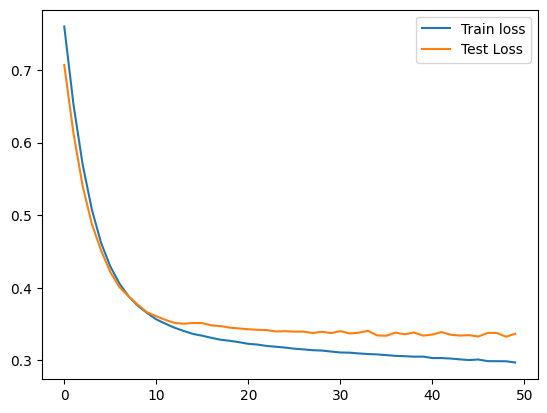

In [18]:
# Visualize the loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend();

In [19]:
preds = model.predict(scaled_X_test).round()
report = classification_report(y_test,preds)
print(report)


8/8 [==============================] - 0s 852us/step
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        90
           1       0.91      0.86      0.89       140

    accuracy                           0.87       230
   macro avg       0.86      0.87      0.86       230
weighted avg       0.87      0.87      0.87       230



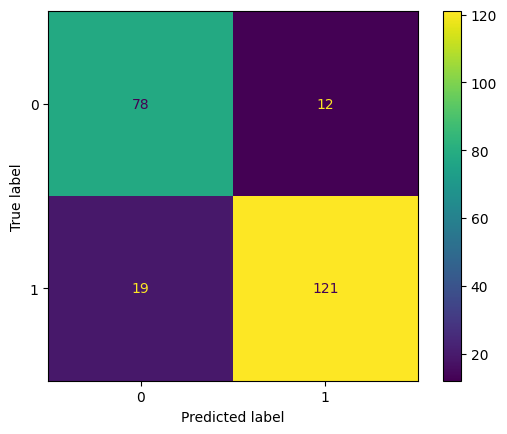

In [20]:
ConfusionMatrixDisplay.from_predictions(y_test,preds)

> This model is very simple, We want to minimize false negatives as they are the worse this model still has significant amount of false negatives

# Model 2

In [21]:
model2 = Sequential()
# Add our Layers
model2.add(Dense(21,input_dim=input_shape, activation='relu'))
model2.add(Dense(10, activation='relu'))
model2.add(Dropout(.2))
# add output layer
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='bce', optimizer='adam')


In [22]:
history = model2.fit(scaled_X_train,y_train,validation_data=(scaled_X_test,y_test), epochs=50)

Epoch 1/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6302 - val_loss: 0.5598
Epoch 2/50
22/22 [==============================] - 0s 2ms/step - loss: 0.5577 - val_loss: 0.5005
Epoch 3/50
22/22 [==============================] - 0s 2ms/step - loss: 0.5114 - val_loss: 0.4660
Epoch 4/50
22/22 [==============================] - 0s 2ms/step - loss: 0.4596 - val_loss: 0.4344
Epoch 5/50
22/22 [==============================] - 0s 2ms/step - loss: 0.4442 - val_loss: 0.4103
Epoch 6/50
22/22 [==============================] - 0s 2ms/step - loss: 0.4287 - val_loss: 0.3946
Epoch 7/50
22/22 [==============================] - 0s 2ms/step - loss: 0.4147 - val_loss: 0.3883
Epoch 8/50
22/22 [==============================] - 0s 2ms/step - loss: 0.3902 - val_loss: 0.3755
Epoch 9/50
22/22 [==============================] - 0s 2ms/step - loss: 0.3786 - val_loss: 0.3686
Epoch 10/50
22/22 [==============================] - 0s 2ms/step - loss: 0.3641 - val_loss: 0.3717
Epoch 11/50
22/22 [

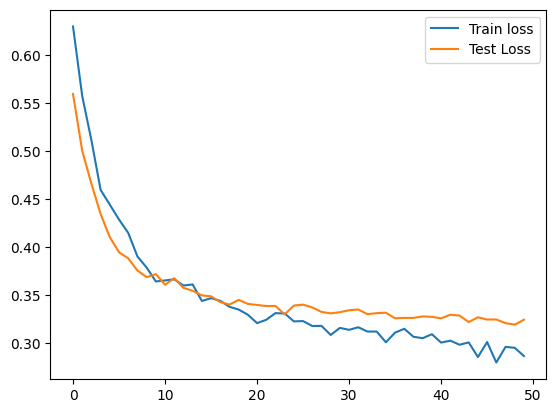

In [23]:
# Visualize the loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend();

In [24]:
preds = model2.predict(scaled_X_test).round()
report = classification_report(y_test,preds)
print(report)

8/8 [==============================] - 0s 654us/step
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        90
           1       0.92      0.88      0.90       140

    accuracy                           0.88       230
   macro avg       0.87      0.88      0.87       230
weighted avg       0.88      0.88      0.88       230



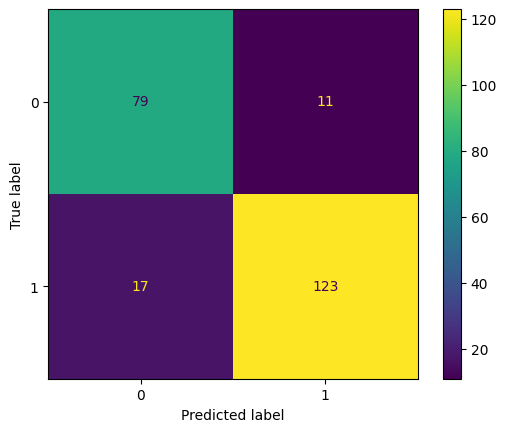

In [25]:
ConfusionMatrixDisplay.from_predictions(y_test,preds)

> Model Preformed about the same as model 1, We still have 17 false negatives which we are working on minimizing. We will add more layers and dropouts to see if this helps any

# Model 3

In [26]:
model3 = Sequential()
# Add our Layers
model3.add(Dense(21,input_dim=input_shape, activation='relu'))
model3.add(Dense(10, activation='relu'))
model3.add(Dropout(.2))
model3.add(Dense(5, activation='relu'))
model3.add(Dropout(.2))
# add output layer
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='bce', optimizer='adam')

In [27]:
history = model3.fit(scaled_X_train,y_train,validation_data=(scaled_X_test,y_test), epochs=60)

Epoch 1/60
22/22 [==============================] - 0s 4ms/step - loss: 0.6826 - val_loss: 0.6606
Epoch 2/60
22/22 [==============================] - 0s 2ms/step - loss: 0.6459 - val_loss: 0.6123
Epoch 3/60
22/22 [==============================] - 0s 2ms/step - loss: 0.6165 - val_loss: 0.5611
Epoch 4/60
22/22 [==============================] - 0s 2ms/step - loss: 0.5816 - val_loss: 0.5129
Epoch 5/60
22/22 [==============================] - 0s 2ms/step - loss: 0.5498 - val_loss: 0.4796
Epoch 6/60
22/22 [==============================] - 0s 2ms/step - loss: 0.5258 - val_loss: 0.4525
Epoch 7/60
22/22 [==============================] - 0s 2ms/step - loss: 0.5025 - val_loss: 0.4314
Epoch 8/60
22/22 [==============================] - 0s 2ms/step - loss: 0.4861 - val_loss: 0.4143
Epoch 9/60
22/22 [==============================] - 0s 2ms/step - loss: 0.4952 - val_loss: 0.4016
Epoch 10/60
22/22 [==============================] - 0s 2ms/step - loss: 0.4548 - val_loss: 0.3894
Epoch 11/60
22/22 [

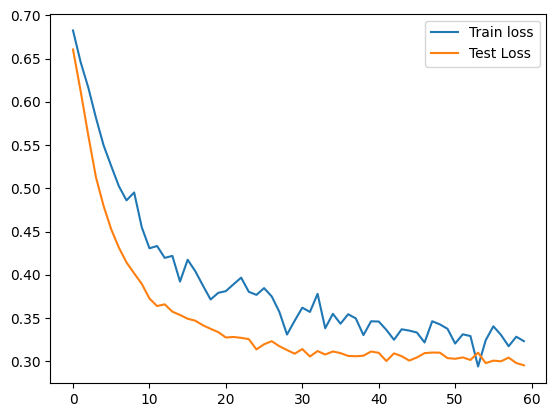

In [28]:
# Visualize the loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend();

In [29]:
preds = model3.predict(scaled_X_test).round()
report = classification_report(y_test,preds)
print(report)

8/8 [==============================] - 0s 696us/step
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        90
           1       0.92      0.86      0.89       140

    accuracy                           0.87       230
   macro avg       0.86      0.87      0.86       230
weighted avg       0.87      0.87      0.87       230



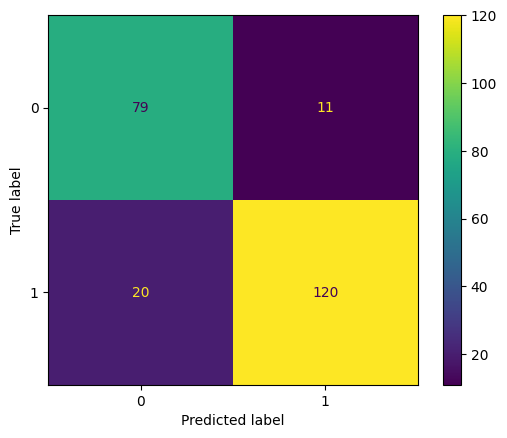

In [30]:
ConfusionMatrixDisplay.from_predictions(y_test,preds)

> This model preformed worse than the other models. This tells us to go simpler with our models and network. This increased false negatives which is something we do not want. 

# Final Model

In [35]:
model2 = Sequential()
# Add our Layers
model2.add(Dense(21,input_dim=input_shape, activation='relu'))
model2.add(Dense(10, activation='relu'))
model2.add(Dropout(.2))
# add output layer
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='bce', optimizer='adam')
history = model2.fit(scaled_X_train,y_train,validation_data=(scaled_X_test,y_test), epochs=50)

Epoch 1/50
22/22 [==============================] - 0s 4ms/step - loss: 0.5666 - val_loss: 0.5153
Epoch 2/50
22/22 [==============================] - 0s 2ms/step - loss: 0.4891 - val_loss: 0.4420
Epoch 3/50
22/22 [==============================] - 0s 2ms/step - loss: 0.4357 - val_loss: 0.3911
Epoch 4/50
22/22 [==============================] - 0s 2ms/step - loss: 0.3977 - val_loss: 0.3606
Epoch 5/50
22/22 [==============================] - 0s 2ms/step - loss: 0.3953 - val_loss: 0.3481
Epoch 6/50
22/22 [==============================] - 0s 2ms/step - loss: 0.3703 - val_loss: 0.3394
Epoch 7/50
22/22 [==============================] - 0s 2ms/step - loss: 0.3592 - val_loss: 0.3422
Epoch 8/50
22/22 [==============================] - 0s 2ms/step - loss: 0.3528 - val_loss: 0.3276
Epoch 9/50
22/22 [==============================] - 0s 2ms/step - loss: 0.3595 - val_loss: 0.3369
Epoch 10/50
22/22 [==============================] - 0s 2ms/step - loss: 0.3447 - val_loss: 0.3296
Epoch 11/50
22/22 [

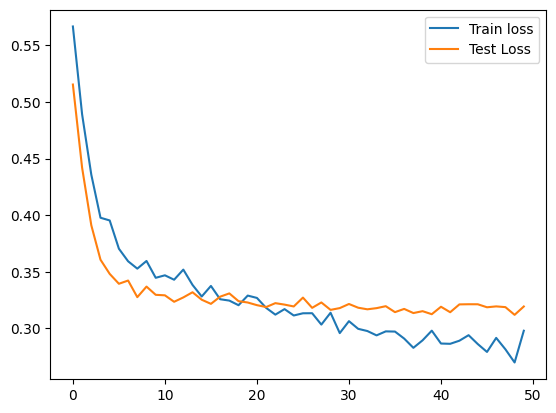

In [36]:
# Visualize the loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend();

In [37]:
preds = model.predict(scaled_X_test).round()
report = classification_report(y_test,preds)
print(report)

8/8 [==============================] - 0s 733us/step
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        90
           1       0.91      0.87      0.89       140

    accuracy                           0.87       230
   macro avg       0.86      0.87      0.86       230
weighted avg       0.87      0.87      0.87       230



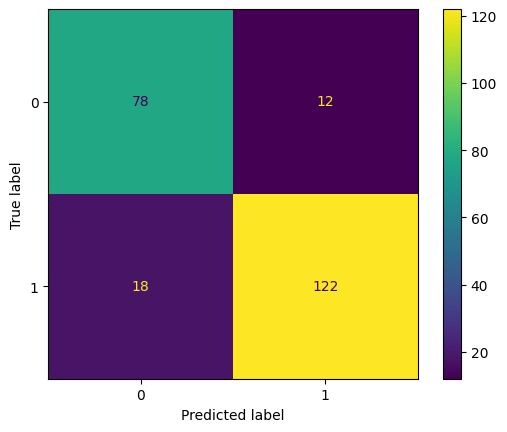

In [38]:
ConfusionMatrixDisplay.from_predictions(y_test,preds)

> The final model is in lines with what we experienced with the models using scikit learn. The neural network did not add much to the model prediction process. This tells us that we could use either a KNN model. 